**Goal**: To build an AI agent with LangGraph framework that takes a meeting audio file as input and returns a structured summary i.e Attendees, Key Discussion Points, Action Items, Decisions Made.
* *Note: Uploaded file should be `.wav` and currently supports only english language*



**Install packages**

In [1]:
!pip install langgraph langchain mistralai gradio --quiet
!pip install faster-whisper --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.5/301.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.

**Import packages**

In [2]:
import json
import os
import requests
from faster_whisper import WhisperModel
from typing import TypedDict
from langgraph.graph import StateGraph

**LLM model used is mistral**

In [15]:
os.environ["MISTRAL_API_KEY"] = "MISTRAL_API_KEY"

**Defining the State**

In [4]:
class State(TypedDict):
    file_path: str
    transcript: str
    summary_json: dict
    final_output: str

**Transcribe the audio**

In [5]:
def transcribe_audio(state: State) -> State:
    model = WhisperModel("base", compute_type="float32")
    segments, _ = model.transcribe(state["file_path"], beam_size=5, language="en")

    transcript = " ".join(segment.text.strip() for segment in segments)
    return {**state, "transcript": transcript}


**Summarize the transcript**

In [6]:
import requests

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
MODEL = "mistral-large-latest"

def summarize_transcript(state: State) -> State:
    prompt = f"""
You are an AI assistant summarizing meeting transcripts.

Extract the following:
1. Attendees (Names only, if possible)
2. Key Discussion Points (bullet format)
3. Action Items (with owner and deadline, if mentioned)
4. Decisions Made (if any)

Respond in this format:
{{
  "attendees": [...],
  "key_points": [...],
  "action_items": [...],
  "decisions": [...]
}}

Transcript:
\"\"\"{state['transcript']}\"\"\"
"""
    res = requests.post(
        "https://api.mistral.ai/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {MISTRAL_API_KEY}",
            "Content-Type": "application/json"
        },
        json={
            "model": MODEL,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": 0.3
        }
    )
    content = res.json()['choices'][0]['message']['content']
    return {**state, "summary_json": eval(content)}


**Format the summary**

In [7]:
def format_output(state: State) -> State:
    summary = state["summary_json"]
    formatted = "📌 Attendees:\n" + "\n".join(f"- {name}" for name in summary["attendees"]) + "\n\n"
    formatted += "💬 Key Points:\n" + "\n".join(f"- {pt}" for pt in summary["key_points"]) + "\n\n"
    formatted += "✅ Action Items:\n" + "\n".join(f"- {item}" for item in summary["action_items"]) + "\n\n"
    formatted += "📎 Decisions:\n" + "\n".join(f"- {d}" for d in summary["decisions"])
    return {**state, "final_output": formatted}


**Build the LangGraph nodes and edges**

In [8]:
from langgraph.graph import StateGraph

builder = StateGraph(State)
builder.add_node("transcribe_audio", transcribe_audio)
builder.add_node("summarize_transcript", summarize_transcript)
builder.add_node("format_output", format_output)

# Link nodes
builder.set_entry_point("transcribe_audio")
builder.add_edge("transcribe_audio", "summarize_transcript")
builder.add_edge("summarize_transcript", "format_output")

graph = builder.compile()


**Visualizing the graph**

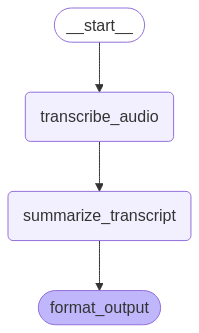

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Testing the agent and printing the workflow**

In [10]:
initial_state = {
    "file_path": "/content/Meeting1.wav"  # Or the actual name you uploaded
}

final_state = graph.invoke(initial_state)

# Show the full structured JSON output
from pprint import pprint
pprint(final_state["summary_json"])

# If you also formatted it into text in `format_output`
print("\n--- Final Summary Text ---\n")
print(final_state.get("final_output", "No final_output found"))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

vocabulary.txt:   0%|          | 0.00/460k [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/145M [00:00<?, ?B/s]

{'action_items': [{'deadline': 'Not specified',
                   'owner': 'Peter Morgan',
                   'task': 'Purchase cheaper option with quality and guarantee '
                           'assurance'},
                  {'deadline': 'Not specified',
                   'owner': 'Mike Reinhardt',
                   'task': 'Update on production figures for last quarter'},
                  {'deadline': 'Not specified',
                   'owner': 'Trudy Finch',
                   'task': 'Summarize recent recruitment programme'},
                  {'deadline': 'Not specified',
                   'owner': 'HR',
                   'task': 'Develop a training calendar and communicate to '
                           'managers'},
                  {'deadline': 'Not specified',
                   'owner': 'Peter Morgan',
                   'task': 'Take the role of involvement in the charity cycle '
                           'ride'}],
 'attendees': ['Carol Fletcher',
             

**Structured summary**

In [14]:
print(final_state["final_output"])

📌 Attendees:
- Carol Fletcher
- Peter Morgan
- Frank Maffer
- Mike Reinhardt
- Trudy Finch

💬 Key Points:
- Introduction of new team member Trudy Finch
- Purchase approval for cheaper option with quality and guarantee assurance
- Production figures update: up by 2% on product streams 1 and 2, down by 0.5% on product stream 3
- Recruitment programme summary: 10 new hires, 9 completed probation
- Discussion on Alpha system implementation: phased rollout vs. swift implementation
- Training programme for Alpha system
- Internet usage policy during lunch breaks
- Charity cycle ride involvement

✅ Action Items:
- {'owner': 'Peter Morgan', 'task': 'Purchase cheaper option with quality and guarantee assurance', 'deadline': 'Not specified'}
- {'owner': 'Mike Reinhardt', 'task': 'Update on production figures for last quarter', 'deadline': 'Not specified'}
- {'owner': 'Trudy Finch', 'task': 'Summarize recent recruitment programme', 'deadline': 'Not specified'}
- {'owner': 'HR', 'task': 'Develop a

**Conclusion**

The AI agent successfully summarized the meeting audio by transcribing it using Whisper, understanding the content through LLMs (like Mistral), and producing a structured summary including Attendees, Key Points, Action Items, and Decisions Made.